<h2>Scrape for Nutritional Information</h2>

In [1]:
import pandas as pd
vgtable = []

In [2]:
def create_vegetable_table(vgstr):
    # Scrapes a wikipedia site for nutritional information for
    # the vegetable given by 'vgstr'.
    # Returns a clean(ish) dataframe.
    
    url = "http://en.wikipedia.org/wiki/" + vgstr
    tables = pd.read_html(url)
    
    # The above panda scrape will return quite a few tables. We want
    # the one that contains nutritional information. In general, this
    # will be the table whose first column contains the word "Nutritional."
    
    for tb in tables:
        if str(tb.columns[0]).find("Nutritional") >= 0:
            dftmp = tb
            break
    
    # Clean the table up by excluding rows containing certain strings.
    
    dftmp.columns = ["Constituent", vgstr]
    dftmp = dftmp.dropna()
    dftmp = dftmp[~dftmp[vgstr].str.contains("Quantity %DV")]
    dftmp = dftmp[~dftmp["Constituent"].str.contains("units")]
    dftmp = dftmp[~dftmp["Constituent"].str.contains("Percentages")]     
    dftmp = dftmp.reset_index(drop=True)
    
    return dftmp   

In [3]:
# Nutritional value per 100 g (3.5 oz)

# Gather the vegetative data from the relevant wikipedia site.
# Each append call returns a clean dataframe, which is then added
# to the vgtable list.

vgtable.append(create_vegetable_table('spinach'))
vgtable.append(create_vegetable_table('cucurbita'))  # This is really squash ...
vgtable.append(create_vegetable_table('broccoli'))
vgtable.append(create_vegetable_table('asparagus'))
vgtable.append(create_vegetable_table('green_bean'))
vgtable.append(create_vegetable_table('eggplant'))
vgtable.append(create_vegetable_table('lentil'))

In [4]:
# Merge dataframes using inner joins so that the master table (vgtable_master)
# contains only attributes common to all tables.

vgtable_master = vgtable[0]
vgtable_master = vgtable_master.merge(vgtable[1], on = 'Constituent', how = 'inner')
vgtable_master = vgtable_master.merge(vgtable[2], on = 'Constituent', how = 'inner')
vgtable_master = vgtable_master.merge(vgtable[3], on = 'Constituent', how = 'inner')
vgtable_master = vgtable_master.merge(vgtable[4], on = 'Constituent', how = 'inner')
vgtable_master = vgtable_master.merge(vgtable[5], on = 'Constituent', how = 'inner')
vgtable_master = vgtable_master.merge(vgtable[6], on = 'Constituent', how = 'inner')

In [5]:
print(vgtable_master)
# Create a csv file for additional work in Pandas.
vgtable_master.to_csv("./vgtable_master.csv")

        Constituent          spinach        cucurbita          broccoli  \
0            Energy  97 kJ (23 kcal)  69 kJ (16 kcal)  141 kJ (34 kcal)   
1     Carbohydrates            3.6 g            3.4 g            6.64 g   
2               Fat            0.4 g            0.2 g            0.37 g   
3           Protein            2.9 g            1.2 g            2.82 g   
4     Thiamine (B1)      7% 0.078 mg      4% 0.048 mg       6% 0.071 mg   
5   Riboflavin (B2)     16% 0.189 mg     12% 0.142 mg      10% 0.117 mg   
6       Niacin (B3)      5% 0.724 mg      3% 0.487 mg       4% 0.639 mg   
7        Vitamin B6     15% 0.195 mg     17% 0.218 mg      13% 0.175 mg   
8       Folate (B9)       49% 194 μg         7% 29 μg         16% 63 μg   
9         Vitamin C        34% 28 mg        20% 17 mg      107% 89.2 mg   
10             Iron      21% 2.71 mg       3% 0.35 mg        6% 0.73 mg   
11        Magnesium        22% 79 mg         5% 17 mg          6% 21 mg   
12       Phosphorus      

In [6]:
# Create dictionaries for inserting into MongoDB.

nutritional_data = []

for xx in vgtable_master.columns[1:]:
    vdict = pd.Series(vgtable_master[xx].values, index=vgtable_master.Constituent).to_dict()
    # Add a field for the vegetable name.
    vdict['Name'] = xx
    nutritional_data.append(vdict)

In [7]:
for _ in nutritional_data:
    print(_)

{'Energy': '97\xa0kJ (23\xa0kcal)', 'Carbohydrates': '3.6 g', 'Fat': '0.4 g', 'Protein': '2.9 g', 'Thiamine (B1)': '7% 0.078 mg', 'Riboflavin (B2)': '16% 0.189 mg', 'Niacin (B3)': '5% 0.724 mg', 'Vitamin B6': '15% 0.195 mg', 'Folate (B9)': '49% 194 μg', 'Vitamin C': '34% 28 mg', 'Iron': '21% 2.71 mg', 'Magnesium': '22% 79 mg', 'Phosphorus': '7% 49 mg', 'Potassium': '12% 558 mg', 'Zinc': '6% 0.53 mg', 'Name': 'spinach'}
{'Energy': '69\xa0kJ (16\xa0kcal)', 'Carbohydrates': '3.4 g', 'Fat': '0.2 g', 'Protein': '1.2 g', 'Thiamine (B1)': '4% 0.048 mg', 'Riboflavin (B2)': '12% 0.142 mg', 'Niacin (B3)': '3% 0.487 mg', 'Vitamin B6': '17% 0.218 mg', 'Folate (B9)': '7% 29 μg', 'Vitamin C': '20% 17 mg', 'Iron': '3% 0.35 mg', 'Magnesium': '5% 17 mg', 'Phosphorus': '5% 38 mg', 'Potassium': '6% 262 mg', 'Zinc': '3% 0.29 mg', 'Name': 'cucurbita'}
{'Energy': '141\xa0kJ (34\xa0kcal)', 'Carbohydrates': '6.64 g', 'Fat': '0.37 g', 'Protein': '2.82 g', 'Thiamine (B1)': '6% 0.071 mg', 'Riboflavin (B2)': '10%

<h2>Mongo DB Creation for Nutrition</h2>

In [ ]:
# Import the pymongo library which will allow us to create and maintain a Mongo DB.
import pymongo

# Create connection variable
conn = 'mongodb://localhost:27017'

# Pass connection to the pymongo instance.
client = pymongo.MongoClient(conn)

# Connect to a database. Create a database called ETL.
db = client.ETL

# Drops collection 'nutrition' if available to remove duplicates.
db.nutrition.drop()

db.nutrition.insert_many(nutritional_data)

<h2>Create Plot of Magnesium Content</h2>

In [9]:
# Look at the magnesium content of the featured vegetables.

vgtable2 = vgtable_master.set_index(["Constituent"])

ll = vgtable2.loc["Magnesium"].values
llval = []

# Extract the content value (in mg) from the content string
# of each vegetable.

for pl in ll:
    llval.append(float(pl.split()[1]))

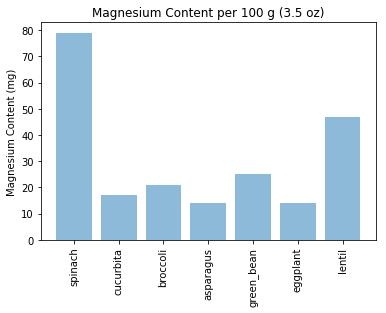

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

xpos = range(len(llval))

plt.bar(xpos, llval, align='center', alpha=0.5)
plt.xticks(xpos, list(vgtable2.columns), rotation = 90)
plt.ylabel('Magnesium Content (mg)')
plt.title('Magnesium Content per 100 g (3.5 oz)')
plt.savefig("Magenesium.jpg")
plt.show()